In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
chunk_size = 10000

In [4]:
# Load v1 & v2 train data

df_train_v1 = pd.read_csv('train.csv')
df_train_v2 = pd.read_csv('train_v2.csv')
df_train = pd.concat([df_train_v1, df_train_v2], ignore_index=True).reset_index(drop=True)
df_train.drop_duplicates('msno',keep='last',inplace=True)

In [5]:
# load test data

df_test = pd.read_csv('sample_submission_v2.csv')

In [6]:
# Load members with msno only in the train data

df_members = pd.read_csv('members_v3.csv')

In [7]:
chunks_trans = pd.read_csv('transactions.csv', iterator=True, chunksize=chunk_size)

df_trans = pd.concat(list(chunks_trans), ignore_index=True)

In [8]:
df_trans = pd.concat([df_trans, pd.read_csv('transactions_v2.csv')], ignore_index=True)

In [11]:
df_logs = pd.DataFrame()

chunks_logs = pd.read_csv('user_logs_v2.csv', iterator=True, chunksize=chunk_size)

for chunk in chunks_logs:
    chunk['num_25'] = chunk['num_25'].astype(np.int16)
    chunk['num_50'] = chunk['num_50'].astype(np.int16)
    chunk['num_75'] = chunk['num_75'].astype(np.int16)
    chunk['num_985'] = chunk['num_985'].astype(np.int16)
    chunk['num_100'] = chunk['num_100'].astype(np.int16)
    chunk['total_secs'] = chunk['total_secs'].astype(np.float32)
    chunk['date'] = chunk['date'].astype(np.int32)
    
    df_logs = pd.concat([df_logs,chunk], ignore_index=True)

In [12]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="city", data=df_members_train, ax=ax[0])
#sns.countplot(x='city', data=df_members_train, ax=ax[1])

In [13]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="registered_via", data=df_members_train, ax=ax[0])
#sns.countplot(x='registered_via', data=df_members_train, ax=ax[1])

# Features engineering for members.csv

In [14]:
# convert date to datetime

df_members['registration_init_dtime'] = pd.to_datetime(df_members['registration_init_time'],format='%Y%m%d')

In [15]:
# get #of days from April 1st to members registration time

from datetime import date

df_members['subscription_days'] = (date(2017,4,1) - df_members['registration_init_dtime']).dt.days

In [16]:
# drop useless columns before merging with transactions

df_members.drop(['gender','bd','registration_init_time','registration_init_dtime','city','registered_via'],axis=1,inplace=True)

In [17]:
#sns.countplot(x='is_churn',data=df_members_train)

In [18]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.distplot(df_members_train['subscription_days'], bins=20, ax=ax[0])
#sns.countplot(x='subscription_days',data=df_members_train,hue='is_churn', palette='YlGnBu')

In [19]:
#sns.pairplot(df_members_train[['city','registered_via','is_churn','subscription_days']], hue='is_churn')

In [20]:
df_members_train = pd.merge(df_members, df_train, on='msno', how='inner')
df_members_test = pd.merge(df_members, df_test, on='msno', how='right')

# Features engineering for transactions.csv

In [21]:
# merge df_trans and df_members_trains so only has to process msnos that are in train.csv

df_merge = pd.merge(df_trans, pd.concat([df_members_train,df_members_test],ignore_index=True), on='msno', how='right')

In [22]:
# remove unnecessary dfs to save memory

del df_members
del df_train_v1
del df_train_v2
del df_members_train
del df_members_test
del df_trans

In [23]:
def df_lower_mem(df):
    df['payment_method_id'] = df['payment_method_id'].astype(np.int8)
    df['payment_plan_days'] = df['payment_plan_days'].astype(np.int16)
    df['plan_list_price'] = df['plan_list_price'].astype(np.int16)
    df['actual_amount_paid'] = df['actual_amount_paid'].astype(np.int16)
    df['is_auto_renew'] = df['is_auto_renew'].astype(np.int8)
    df['is_cancel'] = df['is_cancel'].astype(np.int8)
    df['is_churn'] = df['is_churn'].astype(np.int8)
    return df

df_merge = df_lower_mem(df_merge)

In [24]:
# drop rows that have no payments

#df_merge = df_merge.drop(df_merge[df_merge['actual_amount_paid'] <= 0].index)

In [25]:
# Re-calculate payment_plan_days if 0

#df_merge['payment_plan_days'] = np.where(df_merge['payment_plan_days']==0,(df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days,df_merge['payment_plan_days'])

#df_merge.loc[df_merge['payment_plan_days']==0,'payment_plan_days'] = (df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days

In [26]:
#Set payment_plan_days back to 0 if re-calculation is -ive


#df_merge.loc[df_merge['payment_plan_days']<0,'payment_plan_days'] = 0

In [27]:
#a If plan_list_price is 0 assume it is actual_amount_paid

#df_merge.loc[df_merge['plan_list_price']<=0,'plan_list_price'] = df_merge['actual_amount_paid']

In [28]:
groupby_msno = df_merge.groupby(df_merge['msno'])

In [29]:
# Count # of transactions

df_merge['trans_count'] = (groupby_msno['payment_method_id'].transform('count')).astype(np.int16)

In [30]:
# Total subscription days

df_merge['total_pay_days'] = (groupby_msno['payment_plan_days'].transform('sum')).astype(np.int16)

In [31]:
# Average payment in each transaction

df_merge['avg_pay'] = (groupby_msno['actual_amount_paid'].transform('mean')).astype(np.int16)

In [32]:
# Total subscription payment

df_merge['total_payments'] = (groupby_msno['actual_amount_paid'].transform('sum')).astype(np.int16)

In [33]:
# Assume is_cancel = 1 with actual payment > 0 is a plan change; count the total number of plan changes

#df_merge['count_plan_change'] = groupby_msno['is_cancel'].transform(lambda x: (x==1).sum())

In [34]:
# Count # of auto_renew

#df_merge['count_auto_renew'] = groupby_msno['is_auto_renew'].transform(lambda x: (x==1).sum())

In [35]:
# Average list Price

df_merge['avg_list_price'] = (groupby_msno['plan_list_price'].transform('mean')).astype(np.int16)

In [36]:
# Keep only the record with the most recent transaction date 

df_merge = df_merge.sort_values(by=['transaction_date'], ascending=False).reset_index(drop=True)
df_merge.drop_duplicates('msno',keep='first',inplace=True)

In [37]:
df_merge['transaction_days'] = pd.to_datetime(df_merge['transaction_date'],format='%Y%m%d')
df_merge['membership_expire_days'] = pd.to_datetime(df_merge['membership_expire_date'],format='%Y%m%d')

In [38]:
# Calculate last transaction is how many days ago from April

df_merge['last_trans_days'] = ((date(2017,4,1) - df_merge['transaction_days']).dt.days).astype(np.int16)

In [39]:
df_merge['membership_expiry_days_fr_April'] = ((date(2017,4,1) - df_merge['membership_expire_days']).dt.days).astype(np.int16)

In [40]:
df_merge.drop(['transaction_date','membership_expire_date','transaction_days','membership_expire_days'],axis=1,inplace=True)

In [41]:
df_merge_train = pd.merge(df_merge.drop('is_churn',axis=1), df_train, on='msno', how='inner')
df_merge_test = pd.merge(df_merge.drop('is_churn',axis=1), df_test, on='msno', how='right')

In [42]:
df_merge_test.drop('is_churn',inplace=True,axis=1)

# Features engineering for user_log.csv

In [43]:
# merge df_trans and df_members_trains so only has to process msnos that are in user_logs.csv

df_merge_logs = pd.merge(df_logs, pd.concat([df_train,df_test],ignore_index=True), on='msno', how='right')

In [44]:
df_merge_logs.fillna(value=0, inplace=True)

In [45]:
def df_logs_lower_mem(df):
    df['num_25'] = df['num_25'].astype(np.int16)
    df['num_50'] = df['num_50'].astype(np.int16)
    df['num_75'] = df['num_75'].astype(np.int16)
    df['num_985'] = df['num_985'].astype(np.int16)
    df['num_100'] = df['num_100'].astype(np.int16)
    df['total_secs'] = df['total_secs'].astype(np.float32)
    df['date'] = df['date'].astype(np.int32)
    df['num_unq'] = df['num_unq'].astype(np.int16)
    df.drop('is_churn',axis=1,inplace=True)
    return df

df_merge_logs = df_logs_lower_mem(df_merge_logs)

del df_logs

In [46]:
df_merge_logs.drop_duplicates(['msno','date'],inplace=True)

In [47]:
logs_groupby_msno = df_merge_logs.groupby(df_merge_logs['msno'])

In [48]:
# Count # of play days

df_merge_logs['play_days'] = (logs_groupby_msno['date'].transform('count')).astype(np.int8)

In [49]:
df_merge_logs.loc[df_merge_logs['date']==0,'play_days'] = 255

In [50]:
# Count # of play days

#df_merge_logs['avg_25'] = (logs_groupby_msno['num_25'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_50'] = (logs_groupby_msno['num_50'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_75'] = (logs_groupby_msno['num_75'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_985'] = (logs_groupby_msno['num_985'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_100'] = (logs_groupby_msno['num_100'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_unq'] = (logs_groupby_msno['num_unq'].transform('mean')).astype(np.int16)

In [51]:
df_merge_logs['total_month_secs'] = (logs_groupby_msno['total_secs'].transform('sum')).astype(np.float32)

In [52]:
# Keep only the record with the most recent transaction date 

df_merge_logs = df_merge_logs.sort_values(by=['date'], ascending=False).reset_index(drop=True)
df_merge_logs.drop_duplicates('msno',keep='first',inplace=True)

In [53]:
df_merge_logs.loc[df_merge_logs['date']!=0,'dtime'] = pd.to_datetime(df_merge_logs[df_merge_logs['date']!=0]['date'],format='%Y%m%d')

In [54]:
df_merge_logs.loc[df_merge_logs['date']!=0,'last_play_days'] = ((date(2017,4,1) - df_merge_logs[df_merge_logs['date']!=0]['dtime']).dt.days).astype(np.int8)

In [55]:
df_merge_logs.drop(['date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100','num_unq', 'total_secs','dtime'],axis=1,inplace=True)

In [56]:
df_merge_train = pd.merge(df_merge_train, df_merge_logs, on='msno', how='inner')
df_merge_test = pd.merge(df_merge_test, df_merge_logs, on='msno', how='left')

# Training the models

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
df_merge_train.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'subscription_days',
       'trans_count', 'total_pay_days', 'avg_pay', 'total_payments',
       'avg_list_price', 'last_trans_days', 'membership_expiry_days_fr_April',
       'is_churn', 'play_days', 'total_month_secs', 'last_play_days'],
      dtype='object')

In [59]:
features = ['payment_method_id',
            'plan_list_price',
            'subscription_days',
            'trans_count',
            'total_pay_days',
            'avg_pay',
            'total_payments',
            'avg_list_price',
            'last_trans_days',
            'membership_expiry_days_fr_April',
            'play_days',
            'total_month_secs', 
            'last_play_days']

X = df_merge_train[features]
y = df_merge_train['is_churn']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Train with XGBoost

In [61]:
from xgboost import XGBClassifier

/Users/whyi/Applications/anaconda/envs/MachineLearning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
xgb = XGBClassifier(max_depth=7,learning_rate=0.02,n_estimators=300,silent=False,objective='binary:logistic', seed=50)

In [63]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=30)

[0]	validation_0-logloss:0.675382	validation_1-logloss:0.675385
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 30 rounds.
[1]	validation_0-logloss:0.658311	validation_1-logloss:0.658319
[2]	validation_0-logloss:0.641898	validation_1-logloss:0.64191
[3]	validation_0-logloss:0.626103	validation_1-logloss:0.626122
[4]	validation_0-logloss:0.610899	validation_1-logloss:0.610925
[5]	validation_0-logloss:0.596247	validation_1-logloss:0.596281
[6]	validation_0-logloss:0.582126	validation_1-logloss:0.582168
[7]	validation_0-logloss:0.568503	validation_1-logloss:0.56855
[8]	validation_0-logloss:0.555362	validation_1-logloss:0.555417
[9]	validation_0-logloss:0.542643	validation_1-logloss:0.542706
[10]	validation_0-logloss:0.530352	validation_1-logloss:0.530419
[11]	validation_0-logloss:0.518481	validation_1-logloss:0.518553
[12]	validation_0-logloss:0.506991	validation_1-logloss:0.507068
[1

[124]	validation_0-logloss:0.115301	validation_1-logloss:0.116125
[125]	validation_0-logloss:0.114363	validation_1-logloss:0.115214
[126]	validation_0-logloss:0.113465	validation_1-logloss:0.114341
[127]	validation_0-logloss:0.112605	validation_1-logloss:0.113504
[128]	validation_0-logloss:0.111762	validation_1-logloss:0.112687
[129]	validation_0-logloss:0.110936	validation_1-logloss:0.111884
[130]	validation_0-logloss:0.110139	validation_1-logloss:0.111111
[131]	validation_0-logloss:0.109434	validation_1-logloss:0.110428
[132]	validation_0-logloss:0.108739	validation_1-logloss:0.109753
[133]	validation_0-logloss:0.10806	validation_1-logloss:0.109095
[134]	validation_0-logloss:0.107408	validation_1-logloss:0.108462
[135]	validation_0-logloss:0.106769	validation_1-logloss:0.107842
[136]	validation_0-logloss:0.106131	validation_1-logloss:0.107222
[137]	validation_0-logloss:0.105525	validation_1-logloss:0.106634
[138]	validation_0-logloss:0.104924	validation_1-logloss:0.106051
[139]	valid

[249]	validation_0-logloss:0.077027	validation_1-logloss:0.079131
[250]	validation_0-logloss:0.076946	validation_1-logloss:0.079056
[251]	validation_0-logloss:0.076871	validation_1-logloss:0.078985
[252]	validation_0-logloss:0.076767	validation_1-logloss:0.078886
[253]	validation_0-logloss:0.076697	validation_1-logloss:0.078824
[254]	validation_0-logloss:0.076595	validation_1-logloss:0.078728
[255]	validation_0-logloss:0.076499	validation_1-logloss:0.078636
[256]	validation_0-logloss:0.076427	validation_1-logloss:0.07857
[257]	validation_0-logloss:0.076353	validation_1-logloss:0.078502
[258]	validation_0-logloss:0.076264	validation_1-logloss:0.078419
[259]	validation_0-logloss:0.076195	validation_1-logloss:0.078356
[260]	validation_0-logloss:0.076128	validation_1-logloss:0.078295
[261]	validation_0-logloss:0.076064	validation_1-logloss:0.078239
[262]	validation_0-logloss:0.075995	validation_1-logloss:0.078176
[263]	validation_0-logloss:0.075938	validation_1-logloss:0.078124
[264]	valid

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=50, silent=False, subsample=1)

# Prediction and Evaluations

In [64]:
predictions = xgb.predict(X_test)
predictions_prob = xgb.predict_proba(X_test)

In [65]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss

In [66]:
print(confusion_matrix(y_test,predictions))

[[280759   2641]
 [  5938  31463]]


In [67]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98    283400
          1       0.92      0.84      0.88     37401

avg / total       0.97      0.97      0.97    320801



In [68]:
print(log_loss(y_test,predictions_prob))

0.0763368527946


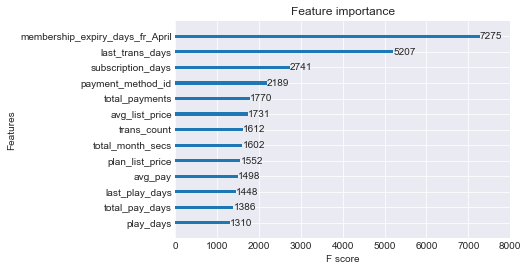

In [69]:
from xgboost import plot_importance

plot_importance(xgb)

# Prediction test file

In [72]:
df_merge_test['is_churn'] = xgb.predict_proba(df_merge_test[features])[:,1]

In [73]:
df_merge_test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')